Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.90647 153.472; 7.39468 154.615; … ; 7.85863 153.979; 8.29571 154.528]

Union{Missing, Float64}[7.6537 155.148; 7.96673 154.132; … ; 7.50225 154.781; 7.78159 154.343]

Union{Missing, Float64}[7.94216 155.292; 8.20173 153.863; … ; 8.12308 154.171; 7.45226 155.33]

Union{Missing, Float64}[8.09321 154.097; 8.02889 154.143; … ; 7.95151 154.105; 7.70382 154.589]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD      Naive SE      MCSE      ESS
sigma   7.7688205 0.30115193 0.00476163 0.0055790804 1000
   mu 154.6132170 0.41517039 0.00656442 0.0070529611 1000

Quantiles:
         2.5%       25.0%     50.0%      75.0%      97.5%  
sigma   7.196618   7.560985   7.76411   7.9671275   8.37595
   mu 153.805950 154.329000 154.61500 154.8950000 155.41505



Plot the density of posterior draws

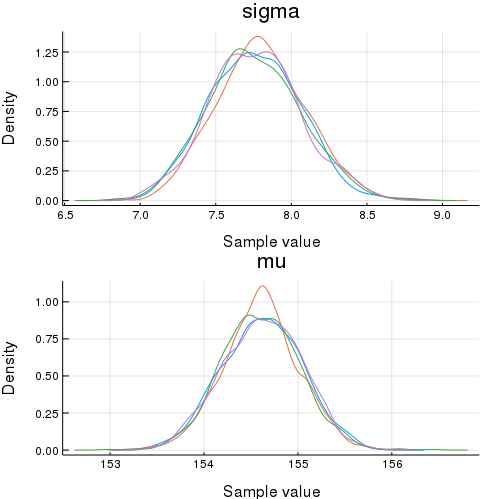

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1812705755745748 
 0.08785153092217328

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0292775
 0.0292775  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*